スタッキングを試した

In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_summary import DataFrameSummary
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

import sys
sys.path.append('../py')
from preprocess import preprocess
from feature_engineering import create_feature

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [4]:
data = preprocess(portfolio, transcript)
data.head()

,person,time,amount,offer_received_at,offer_id,offer_deadline,offer_viewed_at,is_influenced_by_offer
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,0.0,ae264e3637204a6fb9bb56bc8210ddfd,168.0,0.0,1
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0.0,2906b810c7d4411798c6938adc9daaa5,168.0,0.0,1
2,54890f68699049c2a04d415abc25e717,0,13.23,NaN,None,NaN,NaN,0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0.0,5a8bc65990b245e5a138643cd4eb9837,72.0,66.0,0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,0.0,fafdcd668e3743c1bb461111dcafc2a4,240.0,6.0,0


In [5]:
ml_import_data = create_feature(data, portfolio, profile)
ml_import_data.head()

,person,offer_id,amount,age,income,difficulty,duration,offer_type,reward,num_channel,...,gender_F,gender_M,gender_O,registar_year_2013,registar_year_2014,registar_year_2015,registar_year_2016,registar_year_2017,registar_year_2018,amount_log
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,8.57,33,72000.0,0,4,informational,0,3,...,0,1,0,0,0,0,0,1,0,2.148268
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,33,72000.0,0,3,informational,0,3,...,0,1,0,0,0,0,0,1,0,3.098289
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,14.11,33,72000.0,5,5,bogo,5,4,...,0,1,0,0,0,0,0,1,0,2.646884
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,82.76,33,72000.0,10,10,discount,2,4,...,0,1,0,0,0,0,0,1,0,4.415945
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,45.08,40,57000.0,20,10,discount,5,2,...,0,0,1,0,0,0,0,0,1,3.808439


In [6]:
data_informational = ml_import_data[ml_import_data.offer_type == 'informational']
data_bogo = ml_import_data[ml_import_data.offer_type == 'bogo']
data_discount = ml_import_data[ml_import_data.offer_type == 'discount']

print('informational data length: ', len(data_informational))
print('bogo data length: ', len(data_bogo))
print('discount data length: ', len(data_discount))

informational data length:  4865
bogo data length:  15116
discount data length:  13644


In [7]:
data_bogo.columns

Index(['person', 'offer_id', 'amount', 'age', 'income', 'difficulty',
       'duration', 'offer_type', 'reward', 'num_channel', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'amount_min',
       'amount_max', 'amount_sum', 'amount_mean', 'amount_count', 'amount_std',
       'amount_median', 'registar_month', 'scaled_difficulty', 'age_group',
       'buy_rate', 'reward_inpact', 'income_growth_potential', 'gender_F',
       'gender_M', 'gender_O', 'registar_year_2013', 'registar_year_2014',
       'registar_year_2015', 'registar_year_2016', 'registar_year_2017',
       'registar_year_2018', 'amount_log'],
      dtype='object')

In [8]:
model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=0)
X = data_bogo.drop([
    'person', 
    'offer_id', 
    'amount',
    'amount_log',
    'offer_type'
], axis=1)

y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5759285573217374
test score: 0.4880954365052498


In [9]:
importance_df = pd.DataFrame({'name':X.columns, 'importance': model.feature_importances_})
importance_df.sort_values(by='importance', ascending=False).head(10)

,name,importance
13,amount_mean,0.546798
12,amount_sum,0.104633
16,amount_median,0.061320
20,buy_rate,0.049502
1,income,0.047735
31,registar_year_2018,0.032645
30,registar_year_2017,0.021091
11,amount_max,0.019182
10,amount_min,0.016965
22,income_growth_potential,0.015117


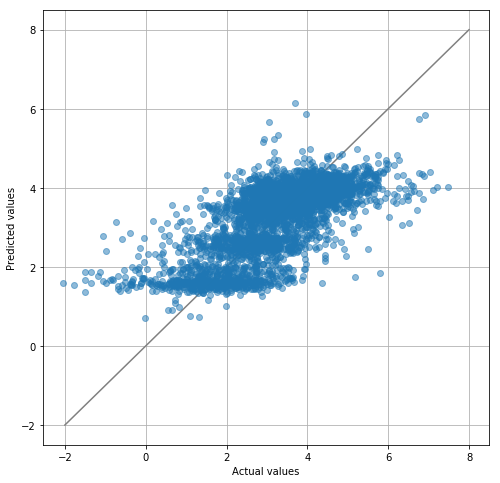

In [10]:
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_test, y_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

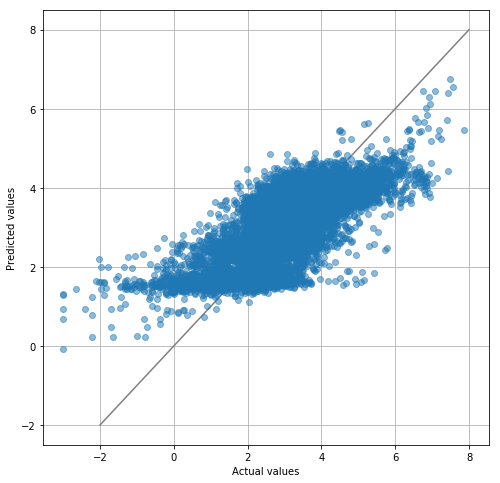

In [11]:
y_train_pred = model.predict(X_train)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_train, y_train_pred, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

### Stacking

In [12]:
model = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=0)
X = data_bogo.drop([
    'person', 
    'offer_id', 
    'amount',
    'amount_log',
    'offer_type'
], axis=1)

y = data_bogo['amount_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
model.fit(X_train, y_train)

print("training score: {}".format(model.score(X_train, y_train)))
print("test score: {}".format(model.score(X_test, y_test)))

training score: 0.5716965540956429
test score: 0.4780616090699446


In [13]:
y_pred = model.predict(X).reshape(-1, 1)
model_stack = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(y_pred, y, random_state=100)
model_stack.fit(X_train, y_train)

print("training score: {}".format(model_stack.score(X_train, y_train)))
print("test score: {}".format(model_stack.score(X_test, y_test)))

training score: 0.586763982671038
test score: 0.4625141944989947


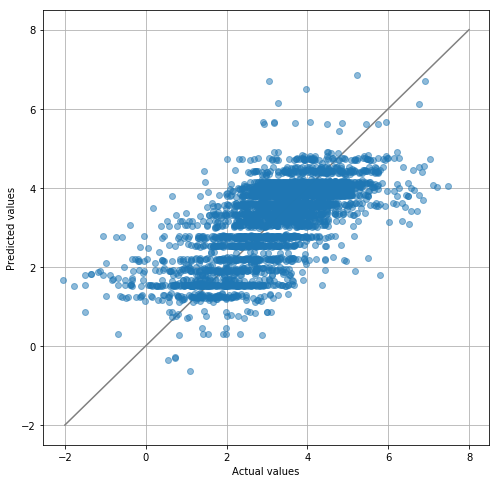

In [15]:
y_pred_stack = model_stack.predict(X_test)

plt.figure(figsize=(8, 8))

plt.plot((-2, 8), (-2, 8), color='gray')
plt.plot(y_test, y_pred_stack, linewidth=0, marker='o', alpha=0.5)
plt.grid()
#plt.xlim((-0.2, 4.2))
#plt.ylim((-0.2, 4.2))
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

お、スタッキングすると精度下がるw

これはまだ特徴量を増やす方が効きそう